In [1]:
import pandas as pd
import numpy as np
import torch
import csv
from sentence_transformers import SentenceTransformer, util
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as func
from torch.nn import Linear as lin
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import string
from sklearn.metrics import confusion_matrix

from torch.distributions.multinomial import Multinomial
from transformers import BertForTokenClassification
from transformers import AutoTokenizer
from transformers import DistilBertTokenizerFast
from transformers import BertTokenizer
from transformers import DistilBertForTokenClassification
from transformers import BertForMaskedLM
from transformers import BertTokenizerFast
from transformers import AutoModelForTokenClassification
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import accuracy_score

/home/henry/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
df = pd.read_csv("Train_Tagged_Titles.tsv.gz", sep="\t", dtype=str, keep_default_na=False, na_values=[""], quoting=csv.QUOTE_NONE)

In [18]:

for i in range(len(df)):
    if type(df["Tag"][i]) == float:
        df["Tag"][i] = "Next"
    

In [4]:
vec_dict = {}
with open("glove.840B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        vals = line.split(" ")
        vec_dict[vals[0]] = np.asarray(vals[1:], dtype="float32")

In [5]:
fileObj = open('word_dict.obj', 'rb')
words = pickle.load(fileObj)

In [6]:
words["Next"] = np.zeros((32,))

In [7]:
model = SentenceTransformer('all-mpnet-base-v2', device="cuda")
rows = []
duds = {}
is_mpn = []
for i in set(df["Tag"].values.tolist()):
    duds[i] = []
nt = []
cnt = 0
pred_idx = 0
for i in range(1,5001):
    if i%100 == 0:
        print(i)
    listing = df[df["Record Number"] == str(i)]
    transformed = []
    #preds_next = next_preds[pred_idx:pred_idx + len(listing)]
    #pred_idx += len(listing) - 1
    
    sent_vec = model.encode(listing["Title"].values[0].lower())
    first = True
    pred_listing = 0
    for idx, row in listing.iterrows():
        """if first:
            sig = 0
            first = False
        else:
            sig = preds_next[pred_listing]
            pred_listing += 1"""
        try:
            tok_vec = vec_dict[row["Token"].lower()]
            transformed.append(np.hstack((sent_vec, tok_vec, words[row["Tag"]])))
        except:
            v = np.zeros((300,))
            div = len(row["Token"])
            for let in row["Token"]:
                if let in vec_dict:
                    v = v + vec_dict[let]
                else:
                    div -= 1
            if div != 0:
                tok_vec = v/div
            else:
                tok_vec = vec_dict["number"]
                
            transformed.append(np.hstack((sent_vec, tok_vec, words[row["Tag"]])))
        
    rows += transformed
vec_dict = None

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [19]:
def get_text(df):
    text = []
    labels = []
    for i in range(1,5001):
        listing = df[df["Record Number"] == str(i)]
        
        text.append(listing["Token"].values.tolist())
        labels.append(listing["Tag"].values.tolist())
    return text, labels

In [5]:
tag_to_id = {}
cnt = 0
for i in set(df["Tag"].values.tolist()):
    
    tag_to_id[i] = cnt
    cnt += 1

In [6]:
id_to_tag = {}
cnt = 0
for i in set(df["Tag"].values.tolist()):
    id_to_tag[cnt] = i
    cnt += 1

In [20]:
text, labels = get_text(df)

In [12]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
all_encodings = tokenizer(text, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

In [6]:
#tokenizer = AutoTokenizer.from_pretrained("nickprock/bert-finetuned-ner-ontonotes")
#tokenizer = AutoTokenizer.from_pretrained("vblagoje/bert-english-uncased-finetuned-pos")
tokenizer = AutoTokenizer.from_pretrained("batterydata/bde-pos-bert-cased-base")

all_encodings = tokenizer(text, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [13]:
def encode_tags(tags, encodings):
    labels = []
    for doc in tags:
        f = []
        for tag in doc:
            f.append(tag_to_id[tag])
        labels.append(f)
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        d = doc_offset
        for i in range(40 - len(d)):
            d.append((0,0))
        doc_enc_labels = np.ones(40,dtype=int) * -100
        arr_offset = np.array(d)
        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = np.array(doc_labels)
        """last = 0
        c = arr_offset[:,1].flatten()
        for v in range(1, len(c)):
            if c[v] == 0:
                for lab in range(1, v+1):
                    if doc_enc_labels[lab] != -100:
                        last = doc_enc_labels[lab]
                    if doc_enc_labels[lab] == -100:
                        doc_enc_labels[lab] = last
                break
            """

        encoded_labels.append(doc_enc_labels.tolist())
    

    return encoded_labels

train_tags = encode_tags(labels, all_encodings)

In [7]:
#bert = BertForMaskedLM.from_pretrained("bert-base-uncased")
#bert = AutoModelForTokenClassification.from_pretrained("vblagoje/bert-english-uncased-finetuned-pos")
#bert = AutoModelForTokenClassification.from_pretrained("nickprock/bert-finetuned-ner-ontonotes")
bert = AutoModelForTokenClassification.from_pretrained("batterydata/bde-pos-bert-cased-base")
#bert.load_state_dict(torch.load("cl_params.obj"))
#bert_8 = deleteEncodingLayers(bert, 10)
#bert_8.eval()
bert.eval() 
r = []
r_8 = []
for i in range(250,5001,250):
    print(i)
    #r_8 += bert_8.bert(input_ids=torch.tensor(all_encodings["input_ids"][i-250:i]).cpu(), attention_mask=torch.tensor(all_encodings["attention_mask"][i-250:i]).cpu())[0].cpu().tolist()
    r+= bert.bert(input_ids=torch.tensor(all_encodings["input_ids"][i-250:i]).cpu(), attention_mask=torch.tensor(all_encodings["attention_mask"][i-250:i]).cpu())[0].cpu().tolist()
r = torch.tensor(r)
#r_8 = torch.tensor(r_8)


250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000


In [8]:
out = []
offset = all_encodings.offset_mapping
for i in range(len(offset)):
    
    row = []
    first = True
    forward = 1
    accm = None
    first_full_zero = True
    for j in range(1, len(offset[i])):
        if offset[i][j][0] == 0 and offset[i][j][1] != 0:
            if first:
                accm = r[i][j]
                first = False
            else:
                accm = accm/forward
                row.append(accm.tolist())
                accm = r[i][j]
                is_same = True
                forward = 1
        elif offset[i][j][0] != 0:
            accm += r[i][j]
            forward += 1
        if offset[i][j][0] == 0 and offset[i][j][1] == 0 and first_full_zero:
            accm = accm/forward
            row.append(accm.tolist())
            first_full_zero = False
    out += row
        


In [15]:
reg_train = np.hstack((np.array(out), np.array(rows)))

In [9]:
reg_train = np.array(out)

In [10]:
ft_bert = np.load("ft_next_bert.npy")
reg_train = np.hstack((reg_train, ft_bert))

In [11]:
np.save("ft_next_bert.npy", reg_train)

In [16]:
bert_out = np.load("ft_next_bert.npy")
bert_out = bert_out.astype(np.float16)[:,:-32]
bert_out = np.hstack(bert_out

In [7]:
p = PCA(n_components=100)

In [7]:
bert_out = np.hstack((bert_out[:,:768*2], bert_out[:,768*3:768*4], bert_out[:,768*5:]))

In [21]:
bert_data = []
count = 0
for m in range(5000):
    listing = labels[m]
    bert_listing = bert_out[count:count + len(listing), :]
    bert_listing = np.hstack((bert_listing[:len(bert_listing)-1, :], bert_listing[1:,:]))
    is_next = []
    for j in range(1, len(listing)):
        prev = listing[j]
        if prev == "Next":
            is_next.append(1)
        else:
            is_next.append(0)
    count += len(listing)
    bert_data += np.hstack((bert_listing, np.array(is_next).reshape(len(is_next), 1))).tolist()
bert_data = np.array(bert_data)

In [8]:
np.save("temp_f.npy", bert_data)

In [10]:
bert_full = np.vstack((np.load("temp_f.npy"), bert_data))

In [22]:
np.save("bert_next.npy", bert_data.astype(np.float16))

In [1]:
from sklearn.metrics import accuracy_score
import csv
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


In [6]:
full_train = np.load("ft_bert.npy")

In [2]:
bert_data = np.load("bert_next.npy")

In [3]:
len(bert_data[0])

8281

In [4]:
s = StandardScaler()
bert_data = np.hstack((s.fit_transform(bert_data[:,:-1]), bert_data[:,-1:]))

In [5]:
s.mean_

array([ 0.96786087,  0.21142467, -0.62581467, ...,  0.02959734,
       -0.08240738, -0.01025654])

In [4]:
filehandler = open('next_scalar.obj', 'wb') 
pickle.dump(s, filehandler)

In [4]:
from sklearn.linear_model import RidgeClassifier
reg = RidgeClassifier()

In [5]:
reg.fit(bert_data[:,:-1], bert_data[:,-1])

RidgeClassifier()

In [12]:
np.save("next_feature_idx.npy",np.where(np.abs(reg.coef_).mean(axis=0) > 0.02)[0])

In [13]:
np.save("next_feature_pca_idx.npy",np.where(np.abs(reg.coef_).mean(axis=0) < 0.02)[0])

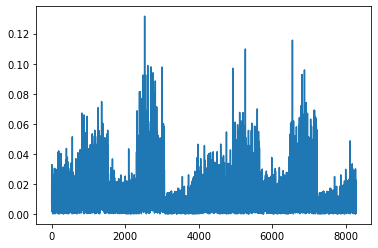

In [6]:
plt.plot(np.arange(len(reg.coef_[0])), np.abs(reg.coef_).mean(axis=0))

In [6]:
len(np.where(np.abs(reg.coef_).mean(axis=0) > 0.02)[0])

1666

In [7]:
s = StandardScaler()
p = PCA(n_components=300)

In [8]:
bert_data = np.hstack((bert_data.T[np.where(np.abs(reg.coef_).mean(axis=0) > 0.02)].T, s.fit_transform(p.fit_transform(bert_data.T[np.where(np.abs(reg.coef_).mean(axis=0) < 0.02)].T)), bert_data[:, -1:]))

In [14]:
len(bert_data[0])

1967

In [16]:
filehandler = open('thresh_next_scalar.obj', 'wb') 
pickle.dump(s, filehandler)

In [17]:
filehandler = open('thresh_next_pca.obj', 'wb') 
pickle.dump(p, filehandler)

In [9]:
np.save("reg_next.npy", bert_data.astype(np.float16))

In [2]:
def eval_func(y_true, y_pred):
    return f1_score(y_pred, y_true, average="weighted", zero_division=1)

In [2]:
bert_data = np.load("reg_next.npy")

In [4]:
train_in, test_in = train_test_split(bert_data, train_size=0.8, random_state=20)

In [7]:

bst = XGBClassifier(n_estimators=3200, min_child_weight=1, learning_rate=0.1, eval_metric="error", max_depth=5,tree_method="gpu_hist", objective='binary:logitraw')

In [8]:
bst.fit(bert_data[:,:-1], bert_data[:,-1:])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3200, n_jobs=0,
              num_parallel_tree=1, objective='binary:logitraw',
              predictor='auto', ...)

In [10]:
print(accuracy_score(bst.predict(test_in[:,:-1]), test_in[:,-1:]))
print(accuracy_score(bst.predict(train_in[:,:-1]), train_in[:,-1:]))

1.0
1.0


In [11]:
filehandler = open('bst_next_params.obj', 'wb') 
pickle.dump(bst, filehandler)

In [5]:
def train_loop_next(model, sample_weights=np.array([]), learning_rate=0.0001, l1=0.00001, batch_size=250, max_iter=3000, sample_func=1/2, nxt=None, not_next=None, test=None):
    test_s = test
    loss_fn = torch.nn.BCELoss(reduction="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    current_min = 999999999
    num_since = 0

    best_params = model.parameters()
    max_val_f1 = 0
    max_train_f1 = 0
    for t in range(200000):
        perm_not = torch.randperm(len(not_next))
        perm_next = torch.randperm(len(nxt))
        nexts = nxt[perm_next][:100]
        not_nexts = not_next[perm_not][:100]
        x_full = torch.vstack((nexts, not_nexts))
        x_train = x_full[:,:-1].cuda()
        y_train = x_full[:,-1].cuda()
        y_pred = model(x_train)
        loss = loss_fn(y_pred.flatten(), y_train)
        for i in model.parameters():
            loss += (torch.square(i).sum())*l1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step(lambda: loss)
        if t%200 == 0:
            temp_test = test_s[:,-1].flatten()
            temp_train = train_s[:,-1].flatten()
            t1 = test_s[:,:-1]
            t2 = train_s[:,:-1]
            test_out = model(t1).flatten()
            train_out = model(t2).flatten()
            val_score = 0
            train_score = 0
            for n in range(len(test_out)):
                if test_out[n] >= 0.5 and temp_test[n] == 1:
                    val_score += 1
                elif test_out[n] <= 0.5 and temp_test[n] == 0:
                    val_score += 1
            for n in range(len(train_out)):
                if train_out[n] >= 0.5 and temp_train[n] == 1:
                    train_score += 1
                elif train_out[n] <= 0.5 and temp_train[n] == 0:
                    train_score += 1
                
            print(t, loss)
            print("train f1: ", train_score/len(train_out))
            print("val f1: ",val_score/len(test_out))
            if val_score > max_val_f1:
                max_val_f1 = val_score
                best_params = model.parameters()
            if train_score > max_train_f1:
                max_train_f1 = val_score
                best_params = model.parameters()
        if loss.item() < current_min:
            num_since = 0
            current_min = loss
            
        elif num_since >= max_iter:
            print("max iter")
            break
        
        else:
            num_since += 1
    
    return (val_score, train_score)


In [6]:
class Model_next(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(len(train_s[0])-1, 128).cuda()
        self.l5 = nn.Linear(128, 1).cuda()
        self.layers = [self.l1, self.l5]
    def forward(self, x):
        #d = nn.Dropout(p=0.5)
        x = self.l1(x)
        x = func.silu(x)
        #x = d(x)
        #x = self.l2(x)
        #x = func.silu(x)
        #x = d(x)
        x = self.l5(x)
        return torch.sigmoid(x)
    def parameters(self):
        params = []
        for p in self.layers:
            params.append(p.weight)
            params.append(p.bias)
        return params

In [117]:
#bert_data = np.hstack((bert_out, np.array(y).reshape(len(y), 1)))
s = StandardScaler()
train_next_bert = s.fit_transform(bert_data[:,:-1])
train_next_bert = np.hstack((train_next_bert, bert_data[:,-1].reshape(len(bert_data[:,-1]),1)))

In [118]:
rows = np.array(rows)
s = StandardScaler()
train_next = s.fit_transform(rows[:,:-1])
train_next = np.hstack((train_next,rows[:,-1].reshape(len(rows[:,-1]),1)))

In [119]:
p = PCA(n_components=10)
t = p.fit_transform(train_next[:,300:-1])
t2 = p.fit_transform(train_next[:,:300])
train_next = np.hstack((t,t2, train_next[:,-1].reshape(len(rows[:,-1]),1)))

In [120]:
p = PCA(n_components=20)
t = p.fit_transform(train_next_bert[:,768:-1])
t2 = p.fit_transform(train_next_bert[:,:768])
train_next_bert = np.hstack((t, t2, train_next_bert[:,-1].reshape(len(train_next_bert), 1)))

In [ ]:
nexts = train_next[np.where(rows[:,-1] == 1)]
not_nexts = train_next[np.where(rows[:,-1] == 0)]

In [ ]:
nexts_bert = train_next_bert[np.where(train_next_bert[:,-1] == 1)]
not_nexts_bert = train_next_bert[np.where(train_next_bert[:,-1] == 0)]

In [ ]:
nexts = np.hstack((nexts_bert[:,:-1], nexts))
not_nexts = np.hstack((not_nexts_bert[:,:-1], not_nexts))

In [ ]:
train_next = np.vstack((nexts, not_nexts[:10000,:]))

In [ ]:
train_s, test_s = train_test_split(train_pca, train_size=0.9)
train_s = torch.tensor(train_s).cuda().float()
test_s = torch.tensor(test_s).cuda().float()

In [121]:
train_next = np.hstack((train_next_bert[:,:-1], train_next))

In [3]:
train_s, test_s = train_test_split(bert_data, train_size=0.9)
train_s = torch.tensor(train_s).cuda().float()
test_s = torch.tensor(test_s).cuda().float()

In [123]:
nexts_in = train_s[torch.where(train_s[:,-1] == 1)]
not_nexts_in = train_s[torch.where(train_s[:,-1] == 0)]
#nexts_in = nexts_in
#not_nexts_in = not_nexts_in



In [7]:
next_mdl = Model_next()

In [8]:
train_loop_next(next_mdl, learning_rate=0.00001, l1=0.001, batch_size=250, max_iter=5000, nxt=train_s[torch.where(train_s[:,-1] == 1)], not_next=train_s[torch.where(train_s[:,-1] == 0)], test=test_s)

0 tensor(0.7200, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.4295246962844728
val f1:  0.4250947536405346
200 tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.7209364192604416
val f1:  0.7267105525633353
400 tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.8348408264609382
val f1:  0.8424097346898065
600 tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.8721512813691584
val f1:  0.8759226012367843
800 tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.8847876208211404
val f1:  0.8874925194494315
1000 tensor(0.3261, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.8934557063048684
val f1:  0.8920805904647915
1200 tensor(0.3312, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.8985767491354083
val f1:  0.8974665868741273
1400 tensor(0.2787, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.9015473973574533
val f1:  0.8988629563135847
1600 tensor(0.3371, device='cuda:0', grad_fn=<AddBackwa

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_28419/83539577.py:1 in <cell line: 1>                                      │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_28419/83539577.py'                   │
│ /tmp/ipykernel_28419/561252675.py:56 in train_loop_next                                   │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_28419/561252675.py'                  │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [1]:
import pandas as pd
import numpy as np
import torch
import csv
from sentence_transformers import SentenceTransformer, util
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as func
from torch.nn import Linear as lin
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import string
from nltk import word_tokenize
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import spacy
from torch.distributions.multinomial import Multinomial
from transformers import BertForTokenClassification
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer
from transformers import DistilBertTokenizerFast
from transformers import BertTokenizer
from transformers import DistilBertForTokenClassification
from transformers import BertForMaskedLM
from transformers import BertTokenizerFast

/home/henry/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-15 21:05:59.414239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 21:05:59.414715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 21:05:59.414846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
trans_train = np.load("transformer_training_array.npy")
attn_mask = np.load("transformer_attention_array.npy")
trans_labels = np.load("transformer_label_array.npy")

In [3]:
trans_labels = np.load("transformer_label_array.npy").tolist()
for m in range(33):
    
    out = []
    for i in range(len(trans_labels)):
        row = []
        for j in range(len(trans_labels[i])):
            if np.array(trans_labels[i][j]).argmax() == m:
                row.append(1)
            else:
                row.append(0)
        out.append(row)
    t = np.array(out)
    if t.sum() == 6921:
        trans_labels = t
        break

In [4]:
def train_loop(model, sample_weights=np.array([]), train_in=None, test_in=None, train_labels=None, test_labels=None, train_attn_mask=None, test_attn_mask=None, learning_rate=0.0001, l1=0.00001, batch_size=250, attention_mask=None, max_iter=3000, sample_func=1/2, data=None, labels=None):
    
    

    loss_fn = torch.nn.BCELoss(reduction="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    current_min = 999999999
    num_since = 0
    best_params = model.parameters()
    max_val_f1 = 0
    max_train_f1 = 0
    train_perm = perm = torch.randperm(len(train_in))
    for t in range(200000):
        #x_full = weighted_sample(weight, train_s, batch_size)
        perm = torch.randperm(len(train_in))
        attn_mask_in = train_attn_mask[perm][:batch_size]
        train_x_in = train_in[perm][:batch_size]
        train_labels_out = train_labels[perm][:batch_size]
        train_labels_out = train_labels_out[torch.where(attn_mask_in == False)]
        y_pred = model(train_x_in, mask=attn_mask_in)[torch.where(attn_mask_in == False)]
        loss = loss_fn(y_pred.flatten(), train_labels_out.flatten())
        a = []
        for p in model.parameters():
            a.append(p)
        loss += torch.abs(a[0]).sum()*l1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step(lambda: loss)
        if t%100 == 0:
            temp_test = test_labels[torch.where(test_attn_mask == False)].detach().cpu().numpy()
            temp_train = train_labels[train_perm][:300][torch.where(train_attn_mask[train_perm][:300] == False)].detach().cpu().numpy()
            test_out = model(test_in, mask=test_attn_mask)[torch.where(test_attn_mask == False)].detach().cpu().numpy()
            train_out = model(train_in[train_perm][:300], mask=train_attn_mask[train_perm][:300])[torch.where(train_attn_mask[train_perm][:300] == False)].detach().cpu().numpy()
            train_score = 0
            val_score = 0
            for n in range(len(test_out)):
                if test_out[n] >= 0.5 and temp_test[n] == 1:
                    val_score += 1
                elif test_out[n] <= 0.5 and temp_test[n] == 0:
                    val_score += 1

            c = 0
            for n in range(len(train_out)):
                if train_out[n] >= 0.5 and temp_train[n] == 1:
                    train_score += 1
                elif train_out[n] <= 0.5 and temp_train[n] == 0:
                    train_score += 1
                c += 1
                
            print(t, loss)
            print("train f1: ", train_score/c)
            print("val f1: ",val_score/len(test_out))
            """if val_score > max_val_f1:
                max_val_f1 = val_score
                best_params = model.parameters()
            if train_score > max_train_f1:
                max_train_f1 = val_score
                best_params = model.parameters()"""
        if loss.item() < current_min:
            num_since = 0
            current_min = loss
            
        elif num_since >= max_iter:
            print("max iter")
            break
        
        else:
            num_since += 1
    
    return (max_val_f1, max_train_f1)

In [9]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.TransformerEncoderLayer(d_model=len(trans_train[0][0]), nhead=9, batch_first=True, dim_feedforward=32,dropout=0.8).cuda()
        #self.enc2 = nn.TransformerEncoderLayer(d_model=len(trans_train[0][0]), nhead=2, batch_first=True, dim_feedforward=32, dropout=0).cuda()
        #self.enc3 = nn.TransformerEncoderLayer(d_model=len(trans_train[0][0]), nhead=4, batch_first=True, dim_feedforward=2048, dropout=0).cuda()
        #self.enc4 = nn.TransformerEncoderLayer(d_model=len(trans_train[0][0]), nhead=4, batch_first=True, dim_feedforward=2048, dropout=0).cuda()
        self.l1 = nn.Linear(len(trans_train[0][0]), 1).cuda()
        #self.l2 = nn.Linear(512, 128).cuda()
        """self.l3 = nn.Linear(512, 128).cuda()
        self.l4 = nn.Linear(128, 128).cuda()
        self.l5 = nn.Linear(128, 128).cuda()
        self.l6 = nn.Linear(128, 128).cuda()"""
        #self.l7 = nn.Linear(128, 33).cuda()
    def forward(self, x, mask=None):
        x = self.enc1(x, src_key_padding_mask=mask)
        #x = self.enc2(x, src_key_padding_mask=mask)
        #x = self.enc3(x, src_key_padding_mask=mask)
        #x = self.enc4(x, src_key_padding_mask=mask)
        x = self.l1(x)
        """x = func.silu(x)

        x = self.l2(x)
        x = func.silu(x)
        
        x = self.l3(x)
        x = func.silu(x)

        skip = x
        x = self.l4(x)
        x = func.silu(x)
        x = x + skip
        skip = x
        x = self.l5(x)
        x = func.silu(x)
        x = x + skip
        skip = x
        x = self.l6(x)
        x = func.silu(x)
        x = x + skip
        x = self.l7(x)"""
        return torch.sigmoid(x)

In [6]:
train_in, test_in, train_labels, test_labels, train_attn_mask, test_attn_mask = train_test_split(trans_train, trans_labels, attn_mask, train_size=0.9)
    
train_in = torch.tensor(train_in).float().cuda()
test_in = torch.tensor(test_in).float().cuda()
train_labels = torch.tensor(train_labels).float().cuda()
test_labels = torch.tensor(test_labels).float().cuda()
train_attn_mask = torch.tensor(train_attn_mask).bool().cuda()
test_attn_mask = torch.tensor(test_attn_mask).bool().cuda()

In [10]:
mdo = Model()

In [12]:
train_loop(mdo, learning_rate=0.0001, l1=0.001, batch_size=25, max_iter=5000, train_in=train_in, test_in=test_in, train_labels=train_labels, test_labels=test_labels, train_attn_mask=train_attn_mask, test_attn_mask=test_attn_mask)

0 tensor(0.2527, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.9486866218692731
val f1:  0.9343267108167771
100 tensor(0.3700, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.9486866218692731
val f1:  0.9328550404709345
200 tensor(0.3437, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.949602932193036
val f1:  0.9332229580573952
300 tensor(0.3144, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.9480757483200978
val f1:  0.9324871228844739
400 tensor(0.4313, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.9480757483200978
val f1:  0.9335908756438558
500 tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.9483811850946854
val f1:  0.9343267108167771
600 tensor(0.3109, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.9434941967012829
val f1:  0.9337748344370861
700 tensor(0.3914, device='cuda:0', grad_fn=<AddBackward0>)
train f1:  0.9517409896151496
val f1:  0.931383370125092
800 tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>)


(0, 0)

In [15]:
torch.cuda.set_per_process_memory_fraction(1.0, device=None)

In [ ]:
preds = next_mdl(torch.tensor(train_next[:,:-1]).cuda().float()).detach().cpu().numpy()
d = pd.DataFrame(data=preds)


In [ ]:
d

,0
0,9.592755e-01
1,1.441378e-07
2,2.334971e-11
3,1.829331e-11
4,1.137788e-04
...,...
50116,4.750222e-04
50117,2.042918e-01
50118,3.029681e-08
50119,7.438381e-07


In [ ]:
d.to_csv("next_preds.csv")

In [26]:
def get_conversion(inp):
    out = []
    for i in inp.flatten():
        if i >= 0.5:
            out.append(1)
        else:
            out.append(0)
    return np.array(out)

In [ ]:
np.set_printoptions(threshold=np.inf)

In [30]:
train_s[:,:-1]

tensor([[-1.0045, -2.2230,  0.4590,  ..., -0.3259, -0.8462, -0.6578],
        [ 0.0914, -0.2589, -0.4519,  ..., -0.2106,  0.2137, -0.6841],
        [-2.4855,  0.7789, -1.3104,  ...,  0.8067,  1.1176,  0.0912],
        ...,
        [ 0.9118, -1.2789, -0.7210,  ..., -0.1166, -0.4972,  0.4478],
        [ 0.4116,  0.8131,  1.2205,  ...,  2.2558, -1.5663,  0.0420],
        [-0.7056,  0.4058, -0.3226,  ...,  1.6992, -0.8753,  0.9845]],
       device='cuda:0')

In [29]:
model(train_s[:,:-1])

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_68899/2946502797.py:1 in <cell line: 1>                                    │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_68899/2946502797.py'                 │
│ /home/henry/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1130 in        │
│ _call_impl                                                                                │
│                                                                                           │
│   1127 │   │   # this function, and just call forward.                                    │
│   1128 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_h │
│   1129 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):            │
│ ❱ 1130 │   │   │   return forward_call(*input, **kwargs)                                  │
│   1131 │   │   # Do not call functions when jit is used                                   │
│   1132 │   │   full_backward_hooks, non_full_backward_hooks = [], []                      │
│   1133 │   │   if self._backward_hooks or _global_backward_hooks:                         │
│                                                                                           │
│ /home/henry/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:139 in      │
│ forward                                                                                   │
│                                                                                           │
│   136 │   # with Any as TorchScript expects a more precise type                           │
│   137 │   def forward(self, input):                                                       │
│   138 │   │   for module in self:                                                         │
│ ❱ 139 │   │   │   input = module(input)                                                   │
│   140 │   │   return input                                                                │
│   141 │                                                                                   │
│   142 │   def append(self, module: Module) -> 'Sequential':                               │
│                                                                                           │
│ /home/henry/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1130 in        │
│ _call_impl                                                                                │
│                                                                                           │
│   1127 │   │   # this function, and just call forward.                                    │
│   1128 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_h │
│   1129 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):            │
│ ❱ 1130 │   │   │   return forward_call(*input, **kwargs)                                  │
│   1131 │   │   # Do not call functions when jit is used                                   │
│   1132 │   │   full_backward_hooks, non_full_backward_hooks = [], []                      │
│   1133 │   │   if self._backward_hooks or _global_backward_hooks:                         │
│                                                                                           │
│ /home/henry/.local/lib/python3.10/site-packages/sentence_transformers/models/Transformer. │
│ py:62 in forward                                                                          │
│                                                                                           │
│    59 │                                                                                   │
│    60 │   def forward(self, features):            

In [103]:
next_mdl.eval()

Model_next(
  (l1): Linear(in_features=220, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=64, bias=True)
  (l5): Linear(in_features=64, out_features=1, bias=True)
)

In [70]:
print(confusion_matrix(get_conversion(next_mdl(train_s[:,:-1]).detach().cpu().numpy()), train_s[:,-1].detach().cpu().numpy().flatten()))
print(confusion_matrix(get_conversion(next_mdl(test_s[:,:-1]).detach().cpu().numpy()), test_s[:,-1].detach().cpu().numpy().flatten()))

[[38538    31]
 [  355  6184]]
[[4184  106]
 [ 123  600]]
